Enter names of students working in a team of two here: [Firstname Surname] [Firstname Surname]

# XCT Exercise 2 – Sinogram and CT Image Reconstruction

The objective of the exercise is to emulate the process of CT data generation (sinogram) and implement various CT
image reconstruction approaches including simple backprojection (BP), filtered backprojection (FBP) and Fourier
transform (FT) based reconstruction. Different filter settings in FBP reconstruction and their impact on image artifacts
and spatial resolution will be investigated.

Some functionality that was implemented in the previous XCT exercise 1 is found in file `local_functions.py`. To use these functionalities the module `local_functions` is imported. Whenever you see a function call or the use of variables such as `local_functions.calculate_discrete_phantom(...)` or `local_functions.tissue_densitities` have a look into the file to understand what the code is doing.

## Imports

In [3]:
from copy import deepcopy
from pint import Quantity
from pdb import set_trace
from typing import Tuple
from scipy.signal import convolve
from scipy.interpolate import griddata

import numpy as np
import matplotlib.pyplot as plt
import local_functions

%matplotlib inline

Default constants:

In [4]:
# Define image matrix size
matrix = (256, 256)

# Define ticks and label for image display
xticks = np.unique(np.concatenate([np.linspace(0, matrix[0]//2, 4), np.linspace(matrix[0]//2, matrix[0], 4)]))
yticks = np.unique(np.concatenate([np.linspace(0, matrix[1]//2, 4), np.linspace(matrix[0]//2, matrix[1], 4)]))
xtick_labels = [f"{t:1.0f}" for t in xticks - matrix[0]//2]
ytick_labels = [f"{t:1.0f}" for t in yticks - matrix[1]//2]

## Section 1 - Sinograms 

The tasks below aim at improving your understanding of sinograms. A sinogram consists of a number of projections taken at different projection angles $\phi$. Plotting a sinogram is done using the projection angle $\phi$ as $x$-coordinate, the detector position $r$ as $y$-coordinate and the intensity corresponding to the projection at the corresponding position ($r$,$\phi$). 

#### Task 1.1
> Construct the object whose sinogram taken at angles of 0 to 180 deg is shown below. You can submit the result by uploading the picture to the folder containing this notebook and 
running the markdown cell below. This will include your image into the notebook cell.
    
![Figure 1](figure1.png)

*Specify your filename in the image import below:*

![Figure ](figure3.png)

#### Task 1.2
> Complete the code in the cell below: 1) Define thorax phantoms for 50 and 150 keV; 2) Calculate projections given projection angles and detector bins; 3) Plot and interpret resulting sinograms (e.g. which sinogram component corresponds to which organ?; what are the differences between sinograms at 50 versus 150 keV?; what range of projection angles is stricly needed?)

> **Hint**: The functions defined in the previous exercise XCT-1 are accessible via the import, e.g. `local_functions.define_thorax_phantom("XXkeV")`

*Type your answer here* 

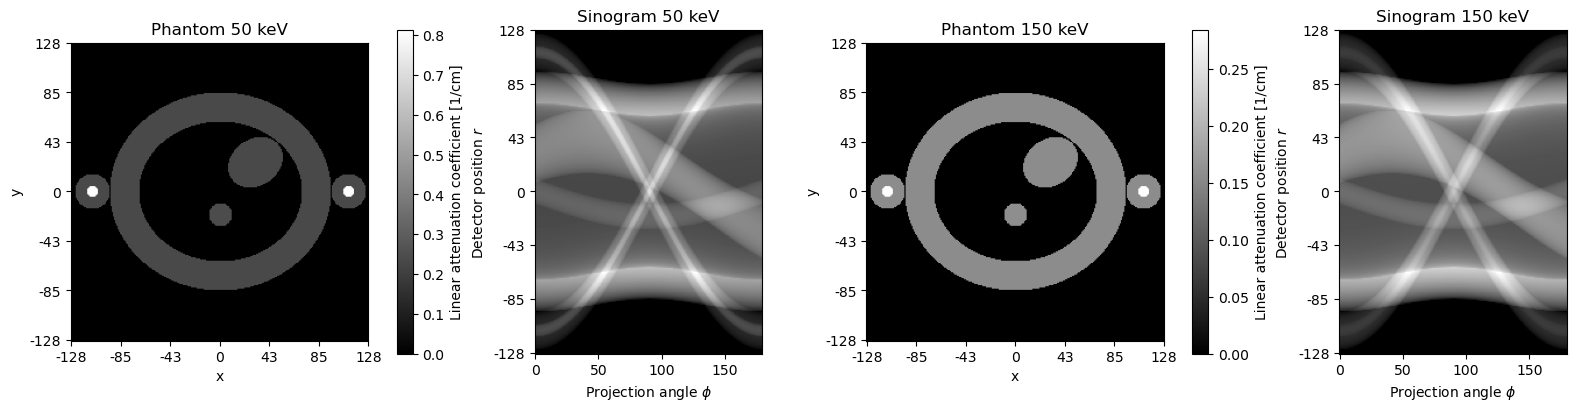

In [5]:
# TASK: Define phantoms
phantom_50keV = local_functions.define_thorax_phantom("50keV")
phantom_150keV = local_functions.define_thorax_phantom("150keV")
# Define projection angles and detector bins
projection_angles = np.arange(0, 180)
detector_bins = 256

# TASK: Calculate sinograms
sinogram_50keV = local_functions.calculate_line_integrals(detector_bins, projection_angles, phantom_50keV)
sinogram_150keV =  local_functions.calculate_line_integrals(detector_bins, projection_angles, phantom_150keV)

# Plot phantom and sinograms 
fig, axes = plt.subplots(1, 4, figsize=(16, 4), constrained_layout=True)

local_functions.display_phantom(phantom_50keV, axes[0], fig)
axes[0].set_title("Phantom 50 keV")

axes[1].imshow(sinogram_50keV.T, origin="lower", cmap="gray")
axes[1].set_yticks(yticks), axes[1].set_yticklabels(ytick_labels)
axes[1].set_xlabel("Projection angle $\phi$"), axes[1].set_ylabel("Detector position $r$")
axes[1].set_title("Sinogram 50 keV")

local_functions.display_phantom(phantom_150keV, axes[2], fig)
axes[2].set_title("Phantom 150 keV")

axes[3].imshow(sinogram_150keV.T, origin="lower", cmap="gray")
axes[3].set_yticks(yticks), axes[3].set_yticklabels(ytick_labels)
axes[3].set_xlabel("Projection angle $\phi$"), axes[3].set_ylabel("Detector position $r$")
axes[3].set_title("Sinogram 150 keV");

## Section 2 - Reconstruction by Simple Backprojection

In the following section simple backprojection from sinogram data will be implemented and studied.

#### Task 2.1
> Implement image reconstruction using simple backprojection by inserting missing code in function `simple_back_projection`; add function calls and display simple projections for 50 keV!

In [6]:
def simple_back_projection(sinogram: np.ndarray, matrix: Tuple[int, int], projection_angles: np.ndarray):
    
    """ Performs simple backprojection reconstruction using sinogram as input.
    
    :param sinogram: array containing sinogram with size (#projection_angles, #detector_bins)
    :param matrix: (int, int) size of image matrix
    :param projection_angles: angles in degree
    """
    
    # Image matrix size
    matrix = np.array(matrix)
    
    # Image matrix coordinates
    x, y = np.meshgrid(np.arange(-np.floor(matrix[0] / 2), np.ceil(matrix[0] / 2)),
                       np.arange(-np.floor(matrix[1] / 2), np.ceil(matrix[1] / 2)), 
                       indexing="ij")    

    # Image matrix
    result = np.zeros(matrix, dtype=np.float64)
   
    # Loop over all projection angles
    for idx, phi in enumerate(projection_angles):
        
        # TASK: Convert from x-y to r-s coordinate (see figure in XCT exercise 1)
        rs = np.around(x * np.sin(np.deg2rad(phi)) + y * np.cos(np.deg2rad(phi)))
        
        # Convert signed rs indices to unsigned rs indices 
        rs = (rs + np.ceil((sinogram.shape[1]) / 2)).astype(int)
        
        # Find rs indices for which sinogram values exist
        ix = np.where(np.logical_and(rs >= 0, rs <= sinogram.shape[1] - 1))
        
        # Copy of sinogram values for given angle phi
        sino = sinogram[idx]
    
        # TASK: Add back-projected sinogram values
        result[ix] = result[ix] + sino[rs[ix]]
        
    return result.T

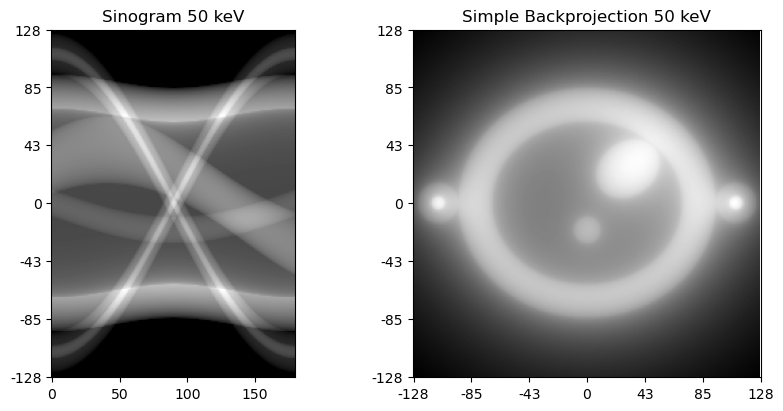

In [7]:
# Calculate simple backprojections from sinograms
image_50keV  = simple_back_projection(sinogram_50keV, matrix, projection_angles)

# Plot sinograms and simple backprojections
fig, axes = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

axes[0].imshow(sinogram_50keV.T, origin="lower", cmap="gray")
axes[0].set_yticks(yticks), axes[0].set_yticklabels(ytick_labels)
axes[0].set_title("Sinogram 50 keV")

axes[1].imshow(image_50keV.T, origin="lower", cmap="gray")
axes[1].set_yticks(yticks), axes[1].set_xticks(xticks);
axes[1].set_yticklabels(ytick_labels), axes[1].set_xticklabels(xtick_labels);
axes[1].set_title("Simple Backprojection 50 keV");

#### Task 2.2
> Explain why the image appears blurred?

*Type your answer here*
partial overlap between different projections

## Section 3 - Reconstruction by Filtered Backprojection

To correct the image blurring observed above, implement filtered backprojection. 

#### Task 3.1
> Complete function `calculate_highpass_filter` below to calculate an ideal highpass filter; plot the Fourier transform pair of the filter!

In [8]:
def calculate_highpass_filter(bins: int) -> Tuple[np.ndarray, np.ndarray]:
    
    """ Calculate highpass filter
    
    :param bins: number of detector bins
    """
    u=np.arange(-np.fix(detector_bins/2), np.fix(detector_bins/2))
    # TASK: Define highpass filter in Fourier domain
    filt =np.abs(np.arange(np.fix(-bins/2), np.fix(bins/2))).real
    
    # TASK: Define highpass filter in image domain 
    filt_ = np.fft.ifftshift(np.fft.ifft(np.fft.fftshift(filt))) 
    
    return filt, filt_

/opt/conda/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/conda/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


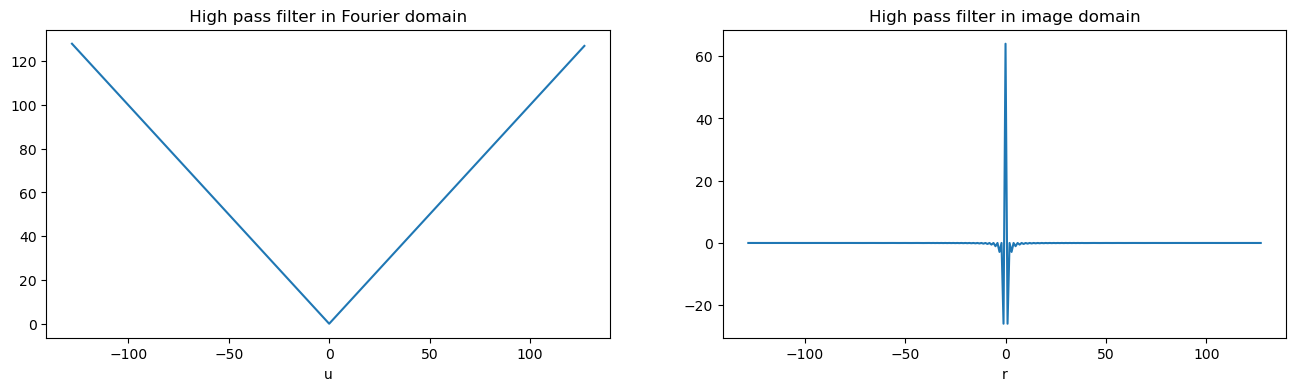

In [9]:
# Calculate highpass filter
filt, filt_ = calculate_highpass_filter(detector_bins)

# Plot kernel and filter 
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].set_title(" High pass filter in Fourier domain ")
axes[0].plot(np.arange(-np.fix(detector_bins/2), np.fix(detector_bins/2)),filt)
axes[0].set_xlabel("u")

axes[1].set_title("High pass filter in image domain");
axes[1].plot(np.arange(-np.fix(detector_bins/2), np.fix(detector_bins/2)),filt_);
axes[1].set_xlabel("r");

#### Task 3.2
> Implement filtered backprojection by copying the content of `simple_back_projection` and by adding application of the highpass filter defined above. 

> **Hint:** Use the imported function `convolve` to apply the filter. Since we want the output with the same size, set the input_argument **mode** accordingly. For more information read https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html

In [13]:
def filtered_back_projection(sinogram: np.ndarray, matrix: Tuple[int, int], projection_angles: np.ndarray, filt: np.ndarray) -> np.ndarray:
   
    """ Performs filtered backprojection reconstruction using sinogram as input.
    
    :param sinogram: array containing the sinogram with shape (#projection_angles, #detector_bins)
    :param matrix: (int, int) size of the targeted reconstruction matrix
    :param projection_angles: angles in degree corresponding to the 0th axis of the sinogram
    :param filt: 1D array with length <= #detector_bins
    """
    
    # Image matrix
    matrix = np.array(matrix)
    
    # Image matrix coordinates
    x, y = np.meshgrid(np.arange(-np.floor(matrix[0] / 2), np.ceil(matrix[0] / 2)),
                       np.arange(-np.floor(matrix[1] / 2), np.ceil(matrix[1] / 2)), 
                       indexing="ij")    

    # Image matrix
    result = np.zeros(matrix, dtype=np.float64)
   
    # Loop over all projection angles
    for idx, phi in enumerate(projection_angles):
        
        # TASK: Convert from x-y to r-s coordinate (see figure in XCT exercise 1)
        rs = np.around(x * np.sin(np.deg2rad(phi)) + y * np.cos(np.deg2rad(phi)))
        
        # Convert signed rs indices to unsigned rs indices 
        rs = (rs + np.ceil((sinogram.shape[1]) / 2)).astype(int)
        
        # Find rs indices for which sinogram values exist
        ix = np.where(np.logical_and(rs >= 0, rs <= sinogram.shape[1] - 1))
        
        # Copy of sinogram values for given angle phi
        sino = sinogram[idx]
        
        # TASK: Perform convolution with highpass filter
        filtered_sino = convolve(sino, filt, 'same')
    
        # TASK: Add back-projected sinogram values
        result[ix] = result[ix] + filtered_sino[rs[ix]]  
        
    return result.T

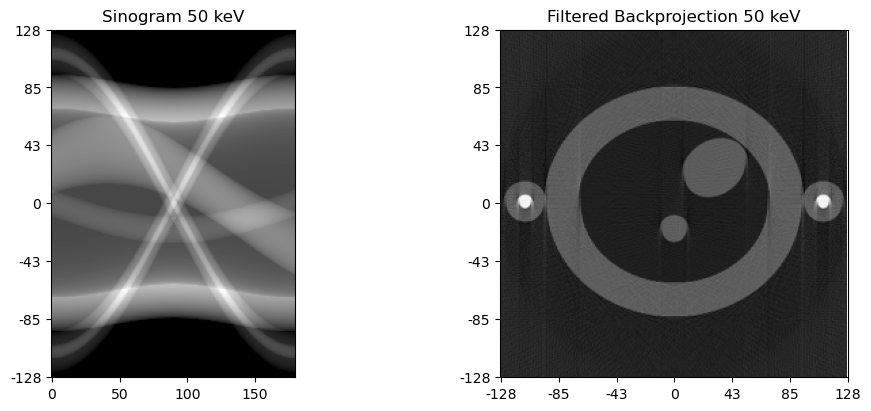

In [14]:
# Calculate filtered backprojections from sinograms
image_50keV  = filtered_back_projection(sinogram_50keV, matrix, projection_angles, filt_)

# Plot sinograms and filtered backprojections
fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

axes[0].imshow(sinogram_50keV.T, origin="lower", cmap="gray")
axes[0].set_yticks(yticks), axes[0].set_yticklabels(ytick_labels)
axes[0].set_title("Sinogram 50 keV")

axes[1].imshow(image_50keV.T, origin="lower", cmap="gray")
axes[1].set_yticks(yticks), axes[1].set_xticks(xticks);
axes[1].set_yticklabels(ytick_labels), axes[1].set_xticklabels(xtick_labels);
axes[1].set_title("Filtered Backprojection 50 keV");

#### Task 3.3 
> Why are “streak” artifacts seen?

*Type your answer here*  : projection angles are not sufficient.

#### Task 3.4 
> Reduce “streaking” by combing the highpass with a lowpass filter (e.g. half a period of a squared cosine function). Plot the Fourier transform pair of the combined filter and discuss trade-offs.

In [18]:
def calculate_combined_filter(bins: int) -> Tuple[np.ndarray, np.ndarray]:
    
    """ Calculate filter by combing highpass with a lowpass filter
    
    :param bins: size of the projection
    """
    u=np.arange(-np.fix(detector_bins/2), np.fix(detector_bins/2))
    # TASK: Define highpass filter in Fourier domain
    filt = np.abs(np.arange(np.fix(-bins/2), np.fix(bins/2)))
    # TASK: Define lowpass weighting
    weight = 0.5 + np.cos(u / bins * 2 * np.pi) /2
    
    # Calculate highpass-lowpass filter
    filt = filt * weight**2
    #filt = weight
    
    # TASK: Define combined filter in image domain 
    filt_ = np.fft.ifftshift(np.fft.ifft(np.fft.fftshift(filt))).real / 2
    
    return filt, filt_

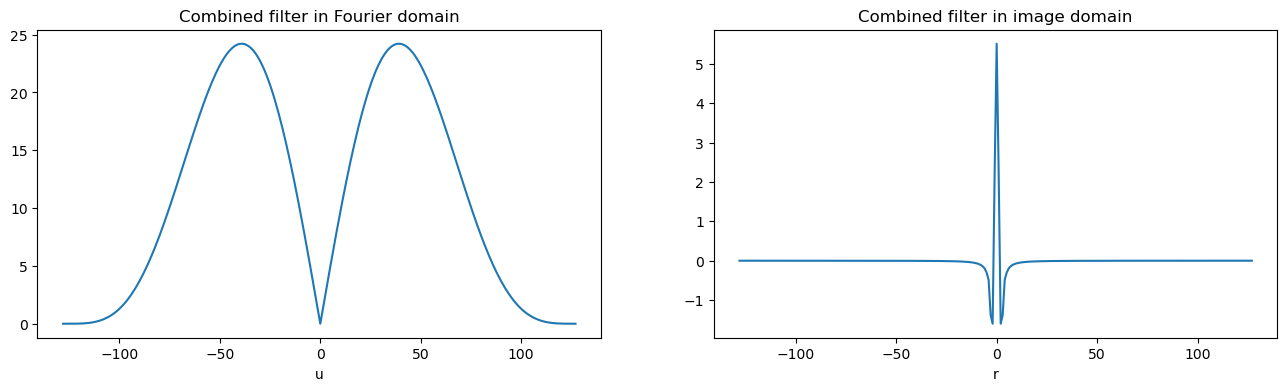

In [19]:
# Calculate combined filter
filt, filt_ = calculate_combined_filter(detector_bins)

# Plot kernel and filter 
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].set_title("Combined filter in Fourier domain")
axes[0].plot(np.arange(-np.fix(detector_bins/2), np.fix(detector_bins/2)),filt)
axes[0].set_xlabel("u")

axes[1].set_title("Combined filter in image domain");
axes[1].plot(np.arange(-np.fix(detector_bins/2), np.fix(detector_bins/2)),filt_);
axes[1].set_xlabel("r");

#### Task 3.5
> Reconstruct images using filtered backprojection with combined highpass-lowpass filter! Compare and discuss results with respect to "streaking" and spatial resolution!  

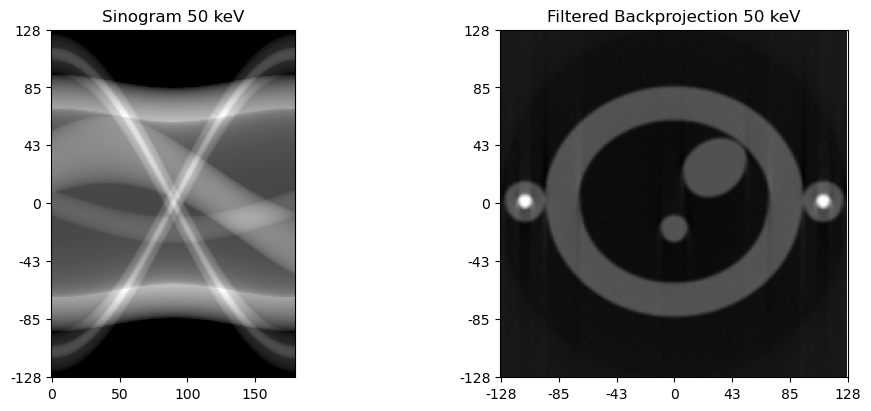

In [20]:
# Calculate filtered backprojections using combined highpass-lowpass filter
image_50keV  = filtered_back_projection(sinogram_50keV, matrix, projection_angles, filt_)

# Plot sinograms and filtered backprojections
fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

axes[0].imshow(sinogram_50keV.T, origin="lower", cmap="gray")
axes[0].set_yticks(yticks), axes[0].set_yticklabels(ytick_labels)
axes[0].set_title("Sinogram 50 keV")

axes[1].imshow(image_50keV.T, origin="lower", cmap="gray")
axes[1].set_yticks(yticks), axes[1].set_xticks(xticks);
axes[1].set_yticklabels(ytick_labels), axes[1].set_xticklabels(xtick_labels);
axes[1].set_title("Filtered Backprojection 50 keV");

*Type your answer here*
:“streaking” and spatial resolution are reduced

## Section 4 - Reconstruction by 2D Fourier Transformation

#### Task 4.1 
> State the Fourier-Slice theorem. Derive the relation between a projection and its Fourier transform!

*Type your answer here*
The Fourier Slice Theorem states that the Fourier transform of a projection of a function f(x,y) , seen from an angle θ, equals the slice of the fourier transform of f(x,y), F(f(x,y)) = F(ωx, ωy), under that angle θ.

#### Task 4.2 
> Implement image reconstruction from projections using the two-dimensional (2D) Fourier transform in function `fourier_reconstruction`! Consider coordinate definitions as shown in the figure below! 

![Figure 2](figure2.png)


In [21]:
def fourier_reconstruction(sinogram: np.ndarray, matrix: Tuple[int, int], projection_angles: np.ndarray) -> np.ndarray:
    
    """ Performs Fourier reconstruction from sinogram.
    
    :param sinogram: array containing the sinogram with size (#projection_angles, #detector_bins)
    :param matrix: (int, int) size of image matrix
    :param projection_angles: angles in degree corresponding to the 0th axis of the sinogram
    """
    
    # Matrix in Fourier domain (p-q domain)
    matrix = np.array(matrix)
    
    # Vector u in Fourier domain (p-q domain)
    u = np.arange(-np.floor(sinogram.shape[1] / 2), np.ceil(sinogram.shape[1] / 2))
    
    # Data matrix in Fourier domain
    data = np.zeros(matrix, dtype=np.complex128)
       
    # Loop over all projection angles
    for idx, phi in enumerate(projection_angles):
        
        # TASK: Convert from u coordinate to p-q coordinates 
        q = (np.around(u * np.cos(np.deg2rad(phi)))).astype(int)
        p = (np.around(u * np.sin(np.deg2rad(phi)))).astype(int)
    
        # TASK: Calculate Fourier transform of projection
        proj_ = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(sinogram[idx])))
        
        # Store Fourier transformed projection in data matrix
        pmin = (np.floor(matrix[0]/2)).astype(int)
        qmin = (np.floor(matrix[1]/2)).astype(int)   
        for i in range(len(u)): data[p[i]-pmin,q[i]-qmin] = proj_[i]
    
    # Set NaNs (Not a Number) to zero 
    data[np.where(np.logical_not(np.isfinite(data)))] = 0   

    # TASK: Calculate image using inverse 2D Fourier transform
    image = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(data)))

    return np.abs(image), np.abs(data)

#### Task 4.3
> Compare reconstruction result with results obtained from filtered backprojection. Why are there image artifacts? (Hint: inspect the Fourier domain data)

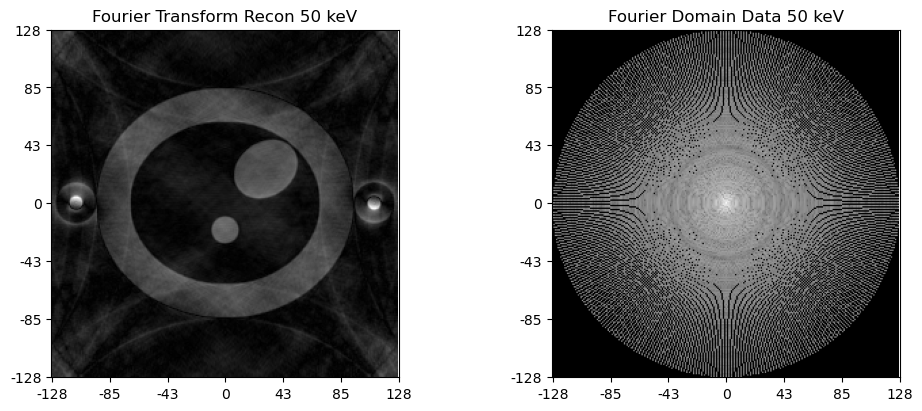

In [22]:
# Calculate Fourier transform reconstructions
image_50keV, data_50keV  = fourier_reconstruction(sinogram_50keV, matrix, projection_angles)

# Plot reconstruction results
fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

axes[0].imshow(image_50keV, origin="lower", cmap="gray")
axes[0].set_yticks(yticks), axes[0].set_xticks(xticks);
axes[0].set_yticklabels(ytick_labels), axes[0].set_xticklabels(xtick_labels);
axes[0].set_title("Fourier Transform Recon 50 keV")

axes[1].imshow(data_50keV**0.1, origin="lower", cmap="gray")
axes[1].set_yticks(yticks), axes[1].set_xticks(xticks);
axes[1].set_yticklabels(ytick_labels), axes[1].set_xticklabels(xtick_labels);
axes[1].set_title("Fourier Domain Data 50 keV");

*Type your answer here* :The data was not uniformly sampled in fourier domain.

#### Task 4.4
> To correct image artifacts, data gridding is used in the Fourier space. Copy missing code from function `fourier_reconstruction` and study what function `griddata` does, see https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html. Explain why the image quality improves!

In [23]:
def fourier_reconstruction_with_gridding(sinogram: np.ndarray, matrix: Tuple[int, int], projection_angles: np.ndarray) -> np.ndarray:
    
    """ Performs Fourier reconstruction from sinogram with data gridding,
    
    :param sinogram: array containing the sinogram with size (#projection_angles, #detector_bins)
    :param matrix: (int, int) size of image matrix
    :param projection_angles: angles in degree corresponding to the 0th axis of the sinogram
    """
    
    # Matrix in Fourier domain (p-q domain)
    matrix = np.array(matrix)
    
    # Matrix coordinates in Fourier domain (p-q domain)
    p, q = np.meshgrid(np.arange(-np.floor(matrix[0] / 2), np.ceil(matrix[0] / 2)),
                       np.arange(-np.floor(matrix[1] / 2), np.ceil(matrix[1] / 2)))    
   
    # Vector u in Fourier domain (p-q domain)
    u = np.arange(-np.floor(sinogram.shape[1] / 2), np.ceil(sinogram.shape[1] / 2))
        
    # Vector to store p-q coordinates
    pq_ = np.zeros([*sinogram.shape, 2], dtype=np.float64)
    
    # Vector to store Fourier transformed projections
    proj_ = np.zeros(sinogram.shape, dtype=np.complex128)

    # Loop over all projection angles
    for idx, phi in enumerate(projection_angles):
        
        # TASK: Convert from u coordinate to p-q coordinates 
        p_ = u * np.cos(np.deg2rad(phi))
        q_ = u * np.sin(np.deg2rad(phi))
        
        # Store p-q coordinates into vector
        pq_[idx] = np.stack([p_, q_], axis=-1)
        
        # TASK: Calculate Fourier transform of projection
        proj_[idx] = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(sinogram[idx])))
        
    # Grid data to Cartesian data grid
    data = griddata(points=pq_.reshape(-1, 2), values=proj_.flatten(), xi=(p,q), method="linear")

    # Set NaNs (Not a Number) to zero 
    data[np.where(np.logical_not(np.isfinite(data)))] = 0   
    
    # TASK: Calculate image using inverse 2D Fourier transform
    image = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(data)))
    
    return np.abs(image), np.abs(data)

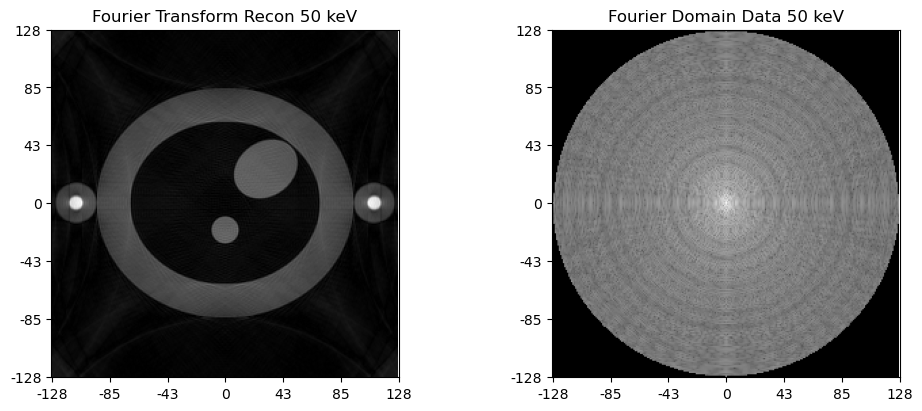

In [24]:
# Calculate Fourier transform reconstructions with gridding
image_50keV, data_50keV  = fourier_reconstruction_with_gridding(sinogram_50keV, matrix, projection_angles)

# Plot reconstruction results
fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

axes[0].imshow(image_50keV, origin="lower", cmap="gray")
axes[0].set_yticks(yticks), axes[0].set_xticks(xticks);
axes[0].set_yticklabels(ytick_labels), axes[0].set_xticklabels(xtick_labels);
axes[0].set_title("Fourier Transform Recon 50 keV")

axes[1].imshow(data_50keV**0.1, origin="lower", cmap="gray")
axes[1].set_yticks(yticks), axes[1].set_xticks(xticks);
axes[1].set_yticklabels(ytick_labels), axes[1].set_xticklabels(xtick_labels);
axes[1].set_title("Fourier Domain Data 50 keV");

*Type your answer here*:When griddata is used, data is interpolated and fourier domain data is more uniform.